<a href="https://colab.research.google.com/github/Rubeennn/Dog_Cat_dataset/blob/main/Cat_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
! pip3 install -q kaggle

In [22]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/home/ruben_ghazaryan/.kaggle’: File exists


In [23]:
! cp kaggle.json ~/.kaggle/

In [24]:
! chmod 600 ~/.kaggle/kaggle.json

In [25]:
! kaggle datasets download -d unmoved/30k-cats-and-dogs-150x150-greyscale

100%|████████████████████████████████████████| 133M/133M [00:34<00:00, 4.01MB/s]
100%|████████████████████████████████████████| 133M/133M [00:34<00:00, 3.98MB/s]


In [6]:
from pathlib import Path

data_path = Path('data')

data_path.mkdir(exist_ok=True, parents=True)


In [27]:
import zipfile

with zipfile.ZipFile('30k-cats-and-dogs-150x150-greyscale.zip', 'r') as z:
    z.extractall(data_path)

In [7]:
cat_path = data_path / 'Animal_Images' / 'cats'
cat_path
dog_path = data_path / 'Animal_Images' / 'dogs'

### Importing the necessary packages

In [8]:
import numpy as np
from PIL import Image
import pandas as pd
import torch
from torch import nn
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
import os

Shape of the image is: (150, 150)


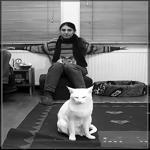

In [76]:
# Visualizing one image
cat_image_names = os.listdir(cat_path)
first_cat_image_path = cat_path / cat_image_names[0]
img = Image.open(fp=first_cat_image_path)
print(f'Shape of the image is: {np.asarray(img).shape}')
img

2. Now we define the path to the image directory
and then gaining the dataset with **ImageFolder**.

In [12]:
path = Path(data_path / 'Animal_Images')

In [36]:
dataset = ImageFolder(
    
    root = path,
    transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(124,124)), # Maybe need to make it smaller
    transforms.ToTensor()
    ])
)

In [37]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [72]:
# Splitting the dataset into train, test and validation datasets.

torch.manual_seed(42)
from torch.utils.data import random_split, DataLoader

train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset) * 0.15)

val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(dataset, 
                                                        [train_size, 
                                                         test_size,
                                                         val_size]
                                                       )


1. Splitting data into batches using the *DataLoader*.

In [42]:

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count()
                             )

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=os.cpu_count()
                        )

val_loader = DataLoader(dataset=val_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False,
                       num_workers=os.cpu_count())

## 3. Bulding the model

In [114]:
class DogCat(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape=2):
        super().__init__()
        
        self.block1 = nn.Sequential(nn.BatchNorm2d(num_features=1),
                                   nn.Conv2d(in_channels=1,
                                             out_channels=3,
                                             kernel_size=(3,3),
                                             stride=1,
                                             padding=1
                                            ),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=3),
                                    nn.Conv2d(in_channels=3,
                                              out_channels=6,
                                              kernel_size=(3,3),
                                              stride=1,
                                              padding=1
                                    ),
                                    nn.MaxPool2d(kernel_size=(3,3)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=6)
                                   )
        
        self.block2 = nn.Sequential(nn.BatchNorm2d(num_features=6),
                                   nn.Conv2d(in_channels=6,
                                             out_channels=9,
                                             kernel_size=(3,3),
                                             stride=1,
                                             padding=1
                                            ),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=9),
                                    nn.Conv2d(in_channels=9,
                                              out_channels=12,
                                              kernel_size=(3,3),
                                              stride=1,
                                              padding=1
                                    ),
                                    nn.MaxPool2d(kernel_size=(3,3)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=12))
        
        self.classifier = nn.Sequential(nn.Flatten(),
                                       nn.Linear(in_features=2028,
                                                out_features=124),
                                        nn.Linear(in_features=124,
                                                 out_features=output_shape)
                                       )
    def forward(self, X):
        print(X.shape)
        X = self.block1(X)
        print(X.shape)
        X = self.block2(X)
        print(X.shape)
        X = self.classifier(X)
        print(X.shape)
        return X

In [115]:
model = DogCat(input_shape=124,
              hidden_shape=10)

In [127]:
train_dataset[0]

(tensor([[[0.9216, 0.9294, 0.9294,  ..., 0.9765, 0.9725, 0.9686],
          [0.9569, 0.9569, 0.9569,  ..., 0.9765, 0.9686, 0.9686],
          [0.9765, 0.9725, 0.9686,  ..., 0.9725, 0.9647, 0.9608],
          ...,
          [0.6000, 0.6196, 0.6275,  ..., 0.6196, 0.6275, 0.6275],
          [0.6314, 0.6549, 0.6588,  ..., 0.6118, 0.6157, 0.6157],
          [0.7255, 0.7412, 0.7333,  ..., 0.6118, 0.6118, 0.6118]]]),
 1)

In [117]:
len(train_dataloader)

329

In [125]:
model.train()
for batch , (X,y) in enumerate(train_dataloader):
    if batch == 100:
        print(torch.softmax(model(X), dim=1))
    

torch.Size([64, 1, 124, 124])
torch.Size([64, 6, 41, 41])
torch.Size([64, 12, 13, 13])
torch.Size([64, 2])
tensor([[0.4952, 0.5048],
        [0.4026, 0.5974],
        [0.5749, 0.4251],
        [0.2508, 0.7492],
        [0.1748, 0.8252],
        [0.7149, 0.2851],
        [0.5990, 0.4010],
        [0.3222, 0.6778],
        [0.3836, 0.6164],
        [0.4233, 0.5767],
        [0.5815, 0.4185],
        [0.6873, 0.3127],
        [0.5745, 0.4255],
        [0.4973, 0.5027],
        [0.6766, 0.3234],
        [0.4381, 0.5619],
        [0.3521, 0.6479],
        [0.3915, 0.6085],
        [0.1297, 0.8703],
        [0.3181, 0.6819],
        [0.5136, 0.4864],
        [0.5386, 0.4614],
        [0.4254, 0.5746],
        [0.4842, 0.5158],
        [0.5181, 0.4819],
        [0.5308, 0.4692],
        [0.3700, 0.6300],
        [0.3623, 0.6377],
        [0.3739, 0.6261],
        [0.3611, 0.6389],
        [0.6188, 0.3812],
        [0.5219, 0.4781],
        [0.5658, 0.4342],
        [0.3853, 0.6147],
        [